In [254]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [255]:
tracks_t = uproot.open("../test.root:diffusion output")
tracks_t.values()
def diffuse(track_dep, z0):
    x=[]
    y=[]
    z=[]
    diff_factor = 0.00323
    z_abs = z0 + 0.72 * 5 * track_dep[2] #0.72 microns/nanosecond
    sigma = diff_factor * np.sqrt(z_abs)
    #print(track_dep[3])
    for c in range(int(track_dep[3])):
        x_new = np.random.normal(track_dep[0],sigma)
        y_new = np.random.normal(track_dep[1],sigma)
        x.append(x_new)
        y.append(y_new)
        #z.append(z_abs)
    return np.array([x,y,z])

def label_nearby(deps,idx,track_idx):
    #deps is depositions
    #given a track_id, identify all pixels with track_id and then label all pixels touching track_id
    
    found=False
    diff=np.diff(deps[:,2])
    for start_pix in deps[np.argwhere(track_idx==idx)]:
        #print(start_pix)
        i_start=start_pix[0][0]
        j_start=start_pix[0][1]
        z_start=start_pix[0][2]
        
        for i, pixel in enumerate(deps):
            
            i_check=pixel[0]
            j_check=pixel[1]
            z_check=pixel[2]
            
            if (not np.isnan(track_idx[i])):
                continue
            #print(start_pix, pixel, diff[i-1])
            #print(np.abs(z_start-z_check))
            if(np.abs(z_start-z_check)<=4):
                dist=np.sqrt((i_check-i_start)**2 + (j_check-j_start)**2)
                if(dist<2):
                    found=True
                    track_idx[i]=idx+1
    if (not found):
        #move on with next nan value
        loc=np.min(np.argwhere(np.isnan(track_idx)))
        track_idx[loc] = idx+1
    return track_idx
def label_track(deps):
    #label all depositions with track ids
    track_idx=np.empty(len(deps))
    track_idx[:]=np.nan
    track_idx[0]=0
    idx=0
    while(np.isnan(np.sum(track_idx))):
        track_idx=label_nearby(deps, idx, track_idx)
        idx+=1
    return track_idx
def average_track(track_ids, deps, charge):
    avg_pixels=[]
    
    for pix_id in range(int(max(track_ids)+1)):

        locs = (np.argwhere(track_ids==pix_id))
        pixels = deps[locs][:,0]
        x_avg=np.average(pixels[:,0])
        y_avg=np.average(pixels[:,1])
        z_avg=np.average(pixels[:,2])
        charge_sum = np.sum(charge[locs])

        avg_pixels.append([x_avg,y_avg,z_avg, charge_sum])
    avg_pixels=np.array(avg_pixels)
    
    return avg_pixels

In [280]:
event_num = 13 #easy ones: 0,2,6,13,14(!) semieasy: 5,11 bad: 15(?),18(need to investigate this one)
x_pix = tracks_t["x_pix"].array()[event_num]
y_pix = tracks_t["y_pix"].array()[event_num]
c_dep = tracks_t["depC_pix"].array()[event_num]
z_toa = tracks_t["z_toa"].array()[event_num]
mean_z = tracks_t["mean_z"].array()[event_num]
z_toa = z_toa - min(z_toa)
print(np.sum(c_dep))

307668


Method: set start pixel idx to 0, set all touching pixels idx to 1 and repeat
then average numbers


154


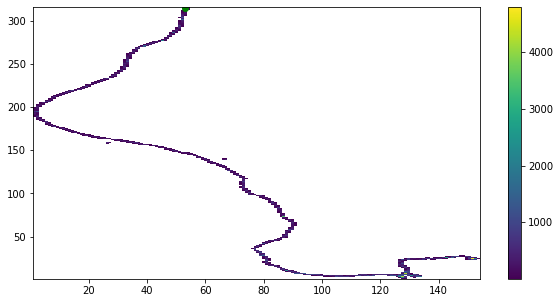

In [281]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (max(x_pix), max(y_pix)), cmin=1, weights=c_dep)
#plt.plot(locs[0],locs[1], 'go')
plt.plot(x_pix[0], y_pix[0],'go')
plt.colorbar()
print(len(pix))

In [282]:
deps=np.dstack((np.array(x_pix),np.array(y_pix),np.array(z_toa)))[0]
track_idx=np.empty(len(deps))
track_idx[:]=np.nan
track_idx[0]=0
idx=0
track_id=label_track(deps)

In [283]:
avg_track=average_track(track_id, deps, c_dep)

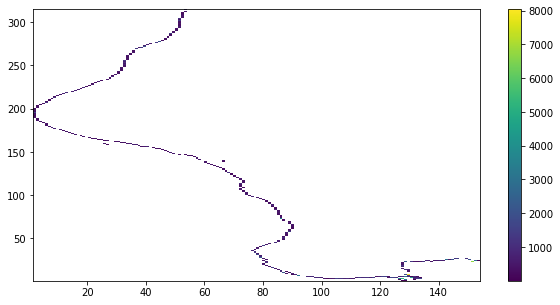

In [284]:
pix, xedges, yedges, image = plt.hist2d(avg_track[:,0], avg_track[:,1], (max(x_pix), max(y_pix)),cmin=1, weights=avg_track[:,3])
plt.colorbar()


/var/folders/ng/nzc5m6m105d49gp2r87w7mjm0000gn/T/ipykernel_1229/1031426599.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x,y,z])


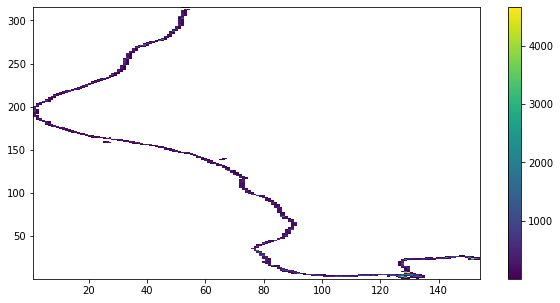

In [285]:
x_new=[]
y_new=[]
#z=[]
for val in avg_track:
    z0=2000#um
    x,y,z=diffuse(val, z0)
    x_new.extend(x)
    y_new.extend(y)
    #z.extend(z)
    
pix, xedges, yedges, image = plt.hist2d(x_new, y_new, (max(x_pix), max(y_pix)),cmin=1)
plt.colorbar()
    
    

In [286]:
mean_z

2275.226806640625

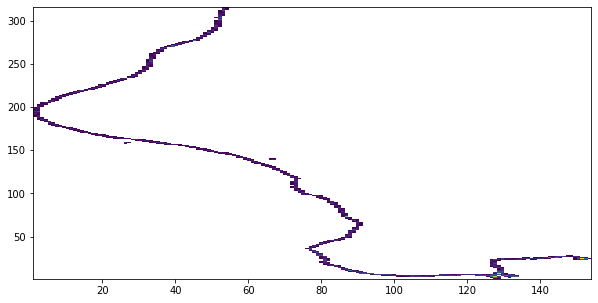

In [287]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (max(x_pix), max(y_pix)), cmin=1, weights=c_dep)


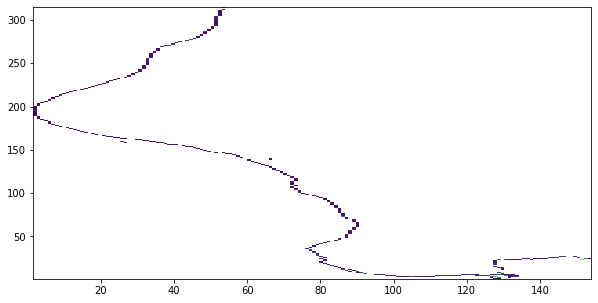

In [288]:
pix, xedges, yedges, image = plt.hist2d(avg_track[:,0], avg_track[:,1], (max(x_pix), max(y_pix)),cmin=1, weights=avg_track[:,3])
